# Random Forests vs Decision Trees
In this notebook, I shall walk through a dataset called the "Heart Disease Dataset" to demonstrate some concets related to Random Forests, you can read more about the dataset [here](https://www.kaggle.com/datasets/johnsmith88/heart-disease-dataset/data).


## Random Forest Introduction

How to build a random forest?

1. Select a sub-set of data. (Bootstrapped dataset)
2. Train a decision tree on the bootstrapped dataset but only use a random subset of features
3. Evaluate the tree: Do OBE or Out-Of-Bag evaluation on the samples that WERE NOT IN THE BOOTSTRAPPED DATASET
4. Repeat Step 1,2 and 3 for a bunch of times until you get a good enough result. 

## Software Dependancies

In [1]:
import os
import random
import sys

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from scipy.stats import chi2_contingency

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, f1_score, recall_score, precision_score




In [2]:
DATA_DIR = "data/"
DATA_EXT = ".data"
RANDOM_STATE = 42

In [3]:
FEATURES = [
"age",
"sex",
"chest_pain_type",
"resting_admission_bp",
"serum_cholesterol",
"fasting_blood_sugar",
"resting_ecg_results",
"max_heart_rate",
"exercise_induced_angina",
"oldpeak",
"slope_peak_st_segment",
"num_vessels_colored",
"thal",
"target"
]

TARGET_COLUMN = "target"

In [4]:
continuous_cols = ["serum_cholesterol",
                   "max_heart_rate",
                   "resting_admission_bp",
                   "oldpeak",
                   "age",
                   "resting_admission_bp"
                  ]
discrete_cols = ["resting_ecg_results",
                 "exercise_induced_angina",
                 "fasting_blood_sugar",
                 "slope_peak_st_segment",
                 "thal",
                 "num_vessels_colored",
                 "sex",
                 "chest_pain_type",
                 
                ]
                 

In [5]:
if not os.path.exists(DATA_DIR):
    print("FATAL: {} does not exist. Please check and re-run this notebook. Exiting..")
    sys.exit(1)

## Dataset Details & Loading Data
- This database contains 76 attributes, but all published experiments refer to using a subset of 14 of them.  
- In particular, the Cleveland database is the only one that has been used by ML researchers to date.  
- The "goal" field refers to the presence of heart disease in the patient.
- It is integer valued from 0 (no presence) to 4.
- Experiments with the Cleveland database have concentrated on simply attempting to distinguish presence (values 1,2,3,4) from absence (value 0).   

<hr>

Data Sources:  
1. Hungarian Institute of Cardiology. Budapest: Andras Janosi, M.D.
2. University Hospital, Zurich, Switzerland: William Steinbrunn, M.D.
3. University Hospital, Basel, Switzerland: Matthias Pfisterer, M.D.
4. V.A. Medical Center, Long Beach and Cleveland Clinic Foundation  


### Load Data

In [6]:
data_files = [f for f in os.listdir(DATA_DIR) if os.path.splitext(f)[-1] == DATA_EXT]
data_files

['hungarian.data',
 'cleveland.data',
 'processed.va.data',
 'switzerland.data',
 'processed.hungarian.data',
 'reprocessed.hungarian.data',
 'new.data',
 'processed.cleveland.data',
 'processed.switzerland.data',
 'long-beach-va.data']

In [7]:
processed_files = [f for f in data_files if f.startswith('processed')]
processed_files

['processed.va.data',
 'processed.hungarian.data',
 'processed.cleveland.data',
 'processed.switzerland.data']

In [8]:
raw_files = list(set(data_files) - set(processed_files))
raw_files

['long-beach-va.data',
 'new.data',
 'hungarian.data',
 'cleveland.data',
 'switzerland.data',
 'reprocessed.hungarian.data']

In [9]:
dfs = []
for f in processed_files:
    fpath = os.path.join(DATA_DIR,f)
    curr_df = pd.read_csv(fpath,
                          names = FEATURES
                         )
    dfs.append(curr_df)

In [10]:
df = pd.concat(dfs,axis=0)

In [11]:
df.head()

,age,sex,chest_pain_type,resting_admission_bp,serum_cholesterol,fasting_blood_sugar,resting_ecg_results,max_heart_rate,exercise_induced_angina,oldpeak,slope_peak_st_segment,num_vessels_colored,thal,target
0,63.0,1.0,4.0,140,260,0,1,112,1,3,2,?,?,2
1,44.0,1.0,4.0,130,209,0,1,127,0,0,?,?,?,0
2,60.0,1.0,4.0,132,218,0,1,140,1,1.5,3,?,?,2
3,55.0,1.0,4.0,142,228,0,1,149,1,2.5,1,?,?,1
4,66.0,1.0,3.0,110,213,1,2,99,1,1.3,2,?,?,0


## Create Target Variable Field
We shall treat 0 as absent and 1,2,3 as present for the heart disease

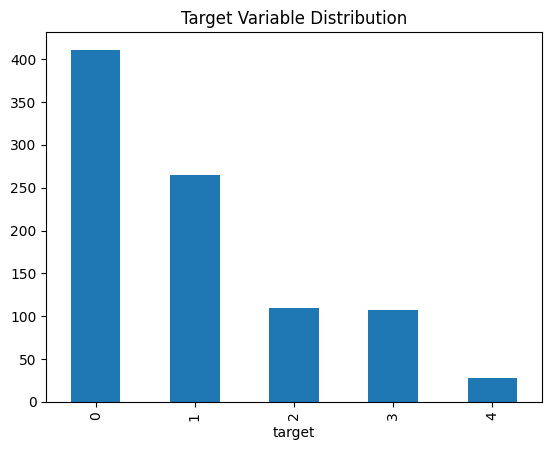

In [12]:
df[TARGET_COLUMN].value_counts().plot(kind = "bar", 
                                      title = "Target Variable Distribution")
plt.show()

In [13]:
def is_heart_patient(value):
    return value > 0

In [14]:
df[TARGET_COLUMN].apply(is_heart_patient)

0       True
1      False
2       True
3       True
4      False
       ...  
118     True
119     True
120    False
121     True
122     True
Name: target, Length: 920, dtype: bool

In [15]:
df[TARGET_COLUMN].head()

0    2
1    0
2    2
3    1
4    0
Name: target, dtype: int64

In [16]:
df[TARGET_COLUMN] = df[TARGET_COLUMN].apply(is_heart_patient).astype(int)

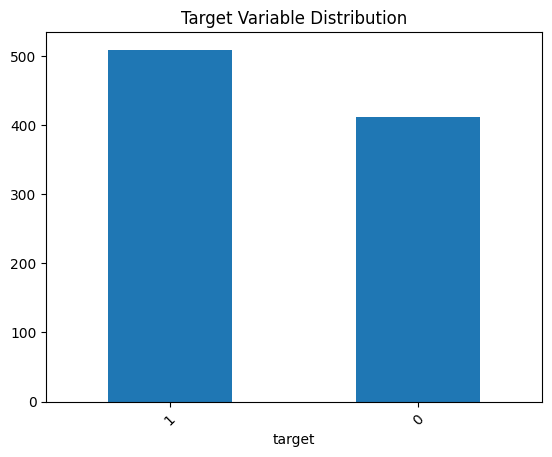

In [17]:
df[TARGET_COLUMN].value_counts().plot(kind = "bar", 
                                      rot = 45,
                                      title = "Target Variable Distribution")
plt.show()

## Data Cleaning

### NA Values & Fixing Column Datatype

In [18]:
df = df.replace("?", np.nan)

Fix column dtype

In [19]:
for col in df.columns:
    if df[col].dtype == object and col != "source":
        df[col] = pd.to_numeric(df[col])

In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 920 entries, 0 to 122
Data columns (total 14 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   age                      920 non-null    float64
 1   sex                      920 non-null    float64
 2   chest_pain_type          920 non-null    float64
 3   resting_admission_bp     861 non-null    float64
 4   serum_cholesterol        890 non-null    float64
 5   fasting_blood_sugar      830 non-null    float64
 6   resting_ecg_results      918 non-null    float64
 7   max_heart_rate           865 non-null    float64
 8   exercise_induced_angina  865 non-null    float64
 9   oldpeak                  858 non-null    float64
 10  slope_peak_st_segment    611 non-null    float64
 11  num_vessels_colored      309 non-null    float64
 12  thal                     434 non-null    float64
 13  target                   920 non-null    int64  
dtypes: float64(13), int64(1)
memory

In [21]:
null_pcts = (100 * (df.isnull().sum() / df.shape[0])).sort_values(ascending=False)
null_pcts

num_vessels_colored        66.413043
thal                       52.826087
slope_peak_st_segment      33.586957
fasting_blood_sugar         9.782609
oldpeak                     6.739130
resting_admission_bp        6.413043
max_heart_rate              5.978261
exercise_induced_angina     5.978261
serum_cholesterol           3.260870
resting_ecg_results         0.217391
age                         0.000000
sex                         0.000000
chest_pain_type             0.000000
target                      0.000000
dtype: float64

In [22]:
null_cols = null_pcts[null_pcts>0]

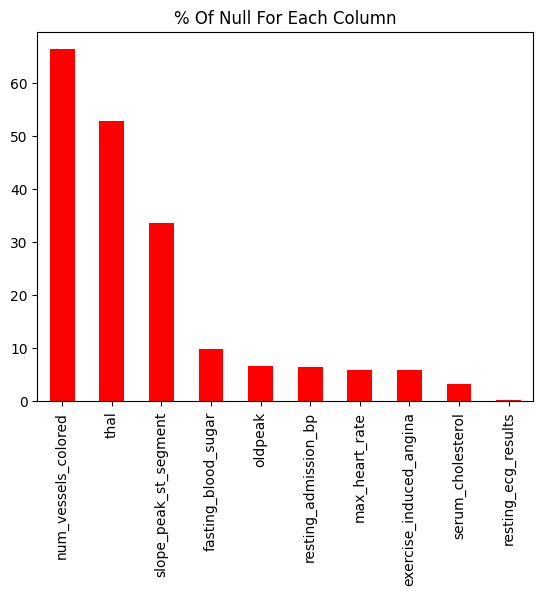

In [23]:
null_cols.plot(kind="bar",
                             title = "% Of Null For Each Column",
                             color = "red")
plt.show()

### Duplicated Rows

In [24]:
df[df.duplicated(keep=False)]

,age,sex,chest_pain_type,resting_admission_bp,serum_cholesterol,fasting_blood_sugar,resting_ecg_results,max_heart_rate,exercise_induced_angina,oldpeak,slope_peak_st_segment,num_vessels_colored,thal,target
139,58.0,1.0,3.0,150.0,219.0,0.0,1.0,118.0,1.0,0.0,NaN,NaN,NaN,1
187,58.0,1.0,3.0,150.0,219.0,0.0,1.0,118.0,1.0,0.0,NaN,NaN,NaN,1
101,49.0,0.0,2.0,110.0,NaN,0.0,0.0,160.0,0.0,0.0,NaN,NaN,NaN,0
102,49.0,0.0,2.0,110.0,NaN,0.0,0.0,160.0,0.0,0.0,NaN,NaN,NaN,0


In [25]:
df = df.drop_duplicates().reset_index(drop=True)

In [26]:
df[df.duplicated(keep=False)]

,age,sex,chest_pain_type,resting_admission_bp,serum_cholesterol,fasting_blood_sugar,resting_ecg_results,max_heart_rate,exercise_induced_angina,oldpeak,slope_peak_st_segment,num_vessels_colored,thal,target


## EDA

#### Correlation Analysis 

In [27]:
df.corr()[TARGET_COLUMN].sort_values()

max_heart_rate            -0.393371
serum_cholesterol         -0.230869
resting_ecg_results        0.062574
resting_admission_bp       0.104018
fasting_blood_sugar        0.142725
age                        0.282039
sex                        0.305445
slope_peak_st_segment      0.337086
oldpeak                    0.386106
num_vessels_colored        0.455599
exercise_induced_angina    0.462422
chest_pain_type            0.471354
thal                       0.498521
target                     1.000000
Name: target, dtype: float64

In [28]:
null_pcts[:3]

num_vessels_colored      66.413043
thal                     52.826087
slope_peak_st_segment    33.586957
dtype: float64

#### Inspecting Impact of fields with highest NA Values On Target

In [29]:
df[TARGET_COLUMN].value_counts()

target
1    508
0    410
Name: count, dtype: int64

#### Chi-Squared test

In [30]:
def chisq_test(feature,
               target):
    contingency_table = pd.crosstab(df[feature],
                                    df[target])
    chi2, p_val, dof, expected = chi2_contingency(contingency_table)
    print("Chi-squared statistic:", chi2)
    '''
    This value, if lesser than 0.05 , then we reject the NULL HYPOTHESIS i.e
    there is no relatoin between the number of vessels and the target 
    '''
    print("p-value:", p_val)
    
    # How many values can the categorical variable assume?
    print("Degrees of freedom:", dof)
    
    # What would the frequencies look like if there was no relationship? 
    print("Expected frequencies table:")
    print(expected)

In [31]:
chisq_test("num_vessels_colored",
           TARGET_COLUMN)

Chi-squared statistic: 73.20029491660873
p-value: 8.805830188183042e-16
Degrees of freedom: 3
Expected frequencies table:
[[96.65048544 84.34951456]
 [35.77669903 31.22330097]
 [21.89320388 19.10679612]
 [10.67961165  9.32038835]]


In [32]:
chisq_test("thal",
           TARGET_COLUMN)

Chi-squared statistic: 109.04739780567616
p-value: 2.092466113570906e-24
Degrees of freedom: 2
Expected frequencies table:
[[ 84.4516129 111.5483871]
 [ 19.8202765  26.1797235]
 [ 82.7281106 109.2718894]]


### Handling NaN Values


We shall keep the original df and for the copy of it, we shall impute the NaNs.

In [33]:
new_df = df.copy()

#### Fill NaNs 

To Do - Try other imputation techniques

In [34]:
for column in df.columns:
    if column in null_cols.index:
        if column in continuous_cols:
            filler = new_df[column].median()
        elif column in discrete_cols:
            filler = new_df[column].mode().iloc[0]
        new_df[column]= new_df[column].fillna(filler)
    else:
        continue

In [35]:
null_cols.index

Index(['num_vessels_colored', 'thal', 'slope_peak_st_segment',
       'fasting_blood_sugar', 'oldpeak', 'resting_admission_bp',
       'max_heart_rate', 'exercise_induced_angina', 'serum_cholesterol',
       'resting_ecg_results'],
      dtype='object')

#### Sanity Check

In [36]:
new_df.isna().sum()

age                        0
sex                        0
chest_pain_type            0
resting_admission_bp       0
serum_cholesterol          0
fasting_blood_sugar        0
resting_ecg_results        0
max_heart_rate             0
exercise_induced_angina    0
oldpeak                    0
slope_peak_st_segment      0
num_vessels_colored        0
thal                       0
target                     0
dtype: int64

#### Check Change In Distirbution

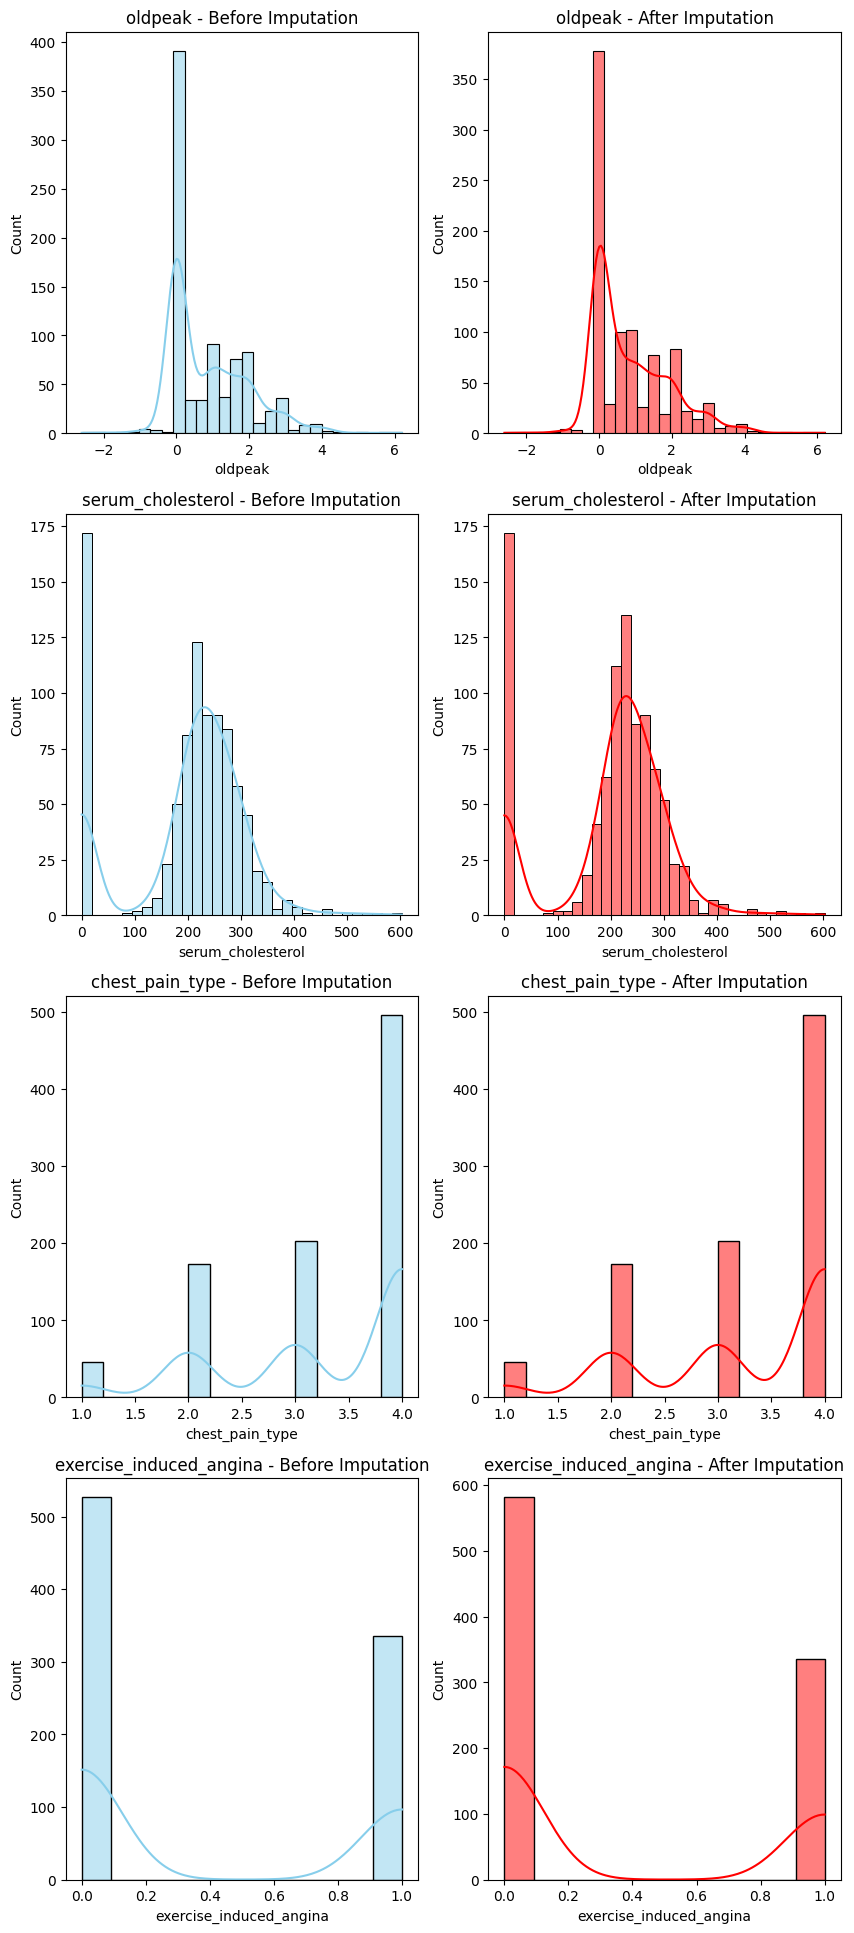

<Figure size 640x480 with 0 Axes>

In [37]:
columns = random.sample(continuous_cols,2) + random.sample(discrete_cols,2)  

rows = len(columns)
cols = 2

fig, axs = plt.subplots(rows, cols, figsize=(10, 6*len(columns)))

ptr = 0 
for idx, col in enumerate(columns):
    sns.histplot(data=df, x=col, color="skyblue",  kde=True, ax=axs[idx, 0 ])
    sns.histplot(data=new_df, x=col, color="red",  kde=True, ax=axs[idx, 1])
    axs[idx, 0 ].set_title("{} - Before Imputation".format(col))
    axs[idx, 1].set_title("{} - After Imputation".format(col))
plt.show()
plt.tight_layout()

### Splitting Data

In [38]:
# Orignal Data 
X , y = new_df.loc[:, new_df.columns != TARGET_COLUMN],  new_df[TARGET_COLUMN]
(X.shape, y.shape) 

((918, 13), (918,))

In [39]:
X.isnull().sum().sum() , y.isnull().sum().sum()

(0, 0)

#### Split The Data

In [40]:
X_train, X_test, y_train, y_test= train_test_split(X, 
                                                   y,
                                                   test_size=0.20,  
                                                   random_state = RANDOM_STATE)

In [41]:
X_train.shape, y_train.shape, X_test.shape,y_test.shape

((734, 13), (734,), (184, 13), (184,))

### Case 1: Decision Tree, Without any Feature Engineering

In [42]:
org_clf = DecisionTreeClassifier(random_state=RANDOM_STATE)

In [43]:
org_clf.fit(X_train, y_train)

DecisionTreeClassifier(random_state=42)

In [44]:
org_clf.get_depth(), org_clf.get_n_leaves(), org_clf.get_params()

(17,
 142,
 {'ccp_alpha': 0.0,
  'class_weight': None,
  'criterion': 'gini',
  'max_depth': None,
  'max_features': None,
  'max_leaf_nodes': None,
  'min_impurity_decrease': 0.0,
  'min_samples_leaf': 1,
  'min_samples_split': 2,
  'min_weight_fraction_leaf': 0.0,
  'random_state': 42,
  'splitter': 'best'})

In [45]:
org_clf.score(X_train, y_train)

1.0

In [46]:
org_clf.score(X_test,y_test)

0.7065217391304348

In [47]:
test_preds = org_clf.predict(X_test)

In [48]:
cm = confusion_matrix(y_test, test_preds)

<Axes: >

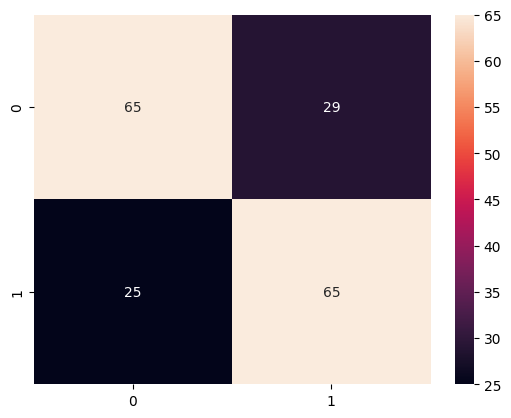

In [49]:
sns.heatmap(cm, annot = True)

In [50]:
f1_score(y_test, test_preds)

0.7065217391304348

#### Check Feature Importance

In [51]:
importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': org_clf.feature_importances_
})

importance_df.sort_values("Importance",
                          ascending=False)
importance_df

,Feature,Importance
0,age,0.130949
1,sex,0.038332
2,chest_pain_type,0.290009
3,resting_admission_bp,0.058933
4,serum_cholesterol,0.177759
5,fasting_blood_sugar,0.018664
6,resting_ecg_results,0.027850
7,max_heart_rate,0.080833
8,exercise_induced_angina,0.016698
9,oldpeak,0.068665


### Case 2: Random Forest, Without any Feature Engineering

In [52]:
org_rf = RandomForestClassifier(n_estimators=25,
                                random_state=RANDOM_STATE)


In [53]:
org_rf.fit(X_train, y_train)

RandomForestClassifier(n_estimators=25, random_state=42)

In [54]:
org_rf.score(X_train, y_train)

0.9986376021798365

In [55]:
org_rf.score(X_test,y_test)

0.8315217391304348

In [56]:
test_preds = org_rf.predict(X_test)

In [57]:
cm = confusion_matrix(y_test, test_preds)
cm

array([[74, 20],
       [11, 79]])

<Axes: >

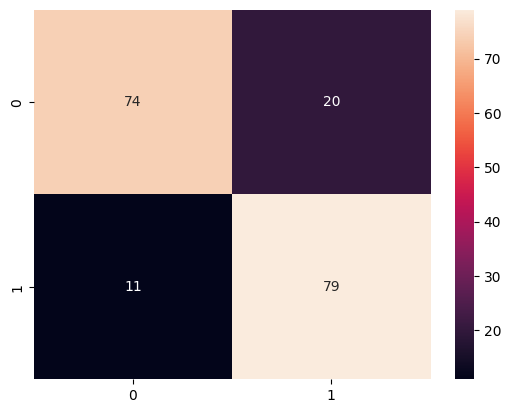

In [58]:
sns.heatmap(cm, annot = True)

In [59]:
f1_score(y_test, test_preds)

0.835978835978836

#### Check Feature Importance

In [60]:
importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': org_rf.feature_importances_
})

importance_df.sort_values("Importance",
                          ascending=False)
importance_df

,Feature,Importance
0,age,0.109723
1,sex,0.039850
2,chest_pain_type,0.156367
3,resting_admission_bp,0.084183
4,serum_cholesterol,0.158327
5,fasting_blood_sugar,0.018918
6,resting_ecg_results,0.026607
7,max_heart_rate,0.128166
8,exercise_induced_angina,0.090339
9,oldpeak,0.110234


### Random Forest - Hyperparamter Tuning

In [61]:
parameters = {'n_estimators': [50, 100, 500] , 
              'max_depth' : [3,5, 7 ]
             }
rf = RandomForestClassifier(random_state = RANDOM_STATE)
rf_clf = GridSearchCV(rf, 
                      parameters)

In [62]:
rf_clf.fit(X_train, y_train)

GridSearchCV(estimator=RandomForestClassifier(random_state=42),
             param_grid={'max_depth': [3, 5, 7],
                         'n_estimators': [50, 100, 500]})

In [63]:
rf_clf.best_score_

0.811965334078837

In [64]:
rf_clf.best_estimator_

RandomForestClassifier(max_depth=7, n_estimators=500, random_state=42)

In [65]:
best_estimator = rf_clf.best_estimator_
best_rf_preds = best_estimator.predict(X_test)
best_estimator.score(X_test,y_test)

0.8695652173913043

In [66]:
f1_score(y_test, best_rf_preds)

0.8723404255319148

In [67]:
cm = confusion_matrix(y_test, best_rf_preds )
cm

array([[78, 16],
       [ 8, 82]])

<Axes: >

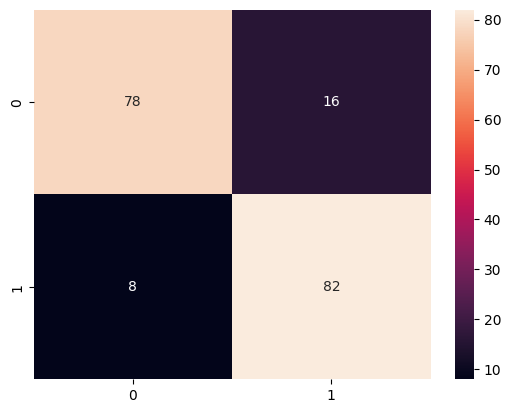

In [68]:
sns.heatmap(cm, annot = True)

In [69]:
# tp / (tp + fp) 
precision_score(y_test, best_rf_preds)

0.8367346938775511

In [70]:
# tp/ (tp + fn) 
recall_score(y_test, best_rf_preds)

0.9111111111111111